In [33]:
!pip install stable_baselines3

In [34]:
import gymnasium as gym
from tqdm import tqdm
#from .autonotebook import tqdm as notebook_tqdm
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from stable_baselines3 import PPO, A2C, SAC, TD3
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from statistics import mean

In [35]:
#define env
env_id = "CartPole-v1"
#env_id = "Acrobot-v1"
env = gym.make(env_id)

In [36]:
#define expert agent
ppo_expert = PPO('MlpPolicy', env_id, verbose=1)

#train expert
ppo_expert.learn(total_timesteps=3e4)

#save expert
ppo_expert.save("ppo_expert")

#evaluate expert
mean_reward, std_reward = evaluate_policy(ppo_expert, Monitor(env), n_eval_episodes=10)
print(f"Mean reward expert agent= {mean_reward} +/- {std_reward}")

Using cpu device
Creating environment from the given name 'CartPole-v1'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.2     |
|    ep_rew_mean     | 23.2     |
| time/              |          |
|    fps             | 1847     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27.1        |
|    ep_rew_mean          | 27.1        |
| time/                   |             |
|    fps                  | 1331        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008492012 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_variance   | -0.0019     |
|    learning_rate        | 0.

In [37]:
##create expert dataset

#empty dataset
num_interactions = int(4e4)

expert_observations = np.empty((num_interactions,) + env.observation_space.shape)
expert_actions = np.empty((num_interactions,) + env.action_space.shape)

print(expert_observations.shape)
print(expert_actions.shape)

#collect experience usign expert policy
obs, _ = env.reset()
for i in tqdm(range(num_interactions)):
    action, _ = ppo_expert.predict(obs, deterministic=True)
    expert_observations[i] = obs
    expert_actions[i] = action
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        obs, _ = env.reset()
        


(40000, 4)
(40000,)


100%|██████████| 40000/40000 [00:09<00:00, 4179.79it/s]


In [38]:
#save dataset
np.savez_compressed(
   "expert_data",
   expert_actions=expert_actions,
   expert_observations=expert_observations,
   )

In [39]:
##dataset class
from torch.utils.data.dataset import Dataset, random_split

class ExpertDataSet(Dataset):

    def __init__(self, expert_observations, expert_actions):
        self.observations = expert_observations
        self.actions = expert_actions

    def __getitem__(self, index):
        return (self.observations[index], self.actions[index])

    def __len__(self):
        return len(self.observations)

In [40]:
expert_dataset = ExpertDataSet(expert_observations, expert_actions)

#split in 80% training and 20%test
batch_size = 64
train_prop = 0.8
train_size = int(train_prop * len(expert_dataset))
test_size = len(expert_dataset) - train_size
train_expert_dataset, test_expert_dataset = random_split(expert_dataset, [train_size, test_size])

train_loader = th.utils.data.DataLoader(  dataset=train_expert_dataset, batch_size=batch_size, shuffle=True)
test_loader = th.utils.data.DataLoader(  dataset=test_expert_dataset, batch_size=batch_size, shuffle=True)

In [41]:
from matplotlib import animation
import matplotlib.pyplot as plt

def save_frames_as_gif(frames, path='./', filename='Behavioral_cloning.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

In [42]:
###### Define student agent
no_cuda = False
use_cuda = not no_cuda and th.cuda.is_available()
print('use_cuda: ', use_cuda)
   
device = th.device("cuda" if use_cuda else "cpu")

class StudentAgent:
    def __init__(self, env, train_loader, test_loader, learning_rate):
        self.env = env
        self.train_loader = train_loader
        self.test_loader = test_loader
        
        n_inputs = env.observation_space.shape[0]
        n_outputs = env.action_space.n
        
        self.policy = nn.Sequential(
            nn.Linear(n_inputs, 16), 
            nn.ReLU(), 
            nn.Linear(16, n_outputs),
            nn.Softmax(dim=-1))
        
        print("policy net: ", self.policy)
        
        self.loss_criterion = nn.CrossEntropyLoss()
        
        self.optimizer =  optim.Adam(self.policy.parameters(), lr=learning_rate)
        
        self.num_eval_episodes = 10
        
    def train(self, num_epochs):
        self.policy.train()
        self.policy.to(device)
        for epoch in range(num_epochs):
            for batch_idx, (data, target) in enumerate(train_loader):
                obs, expert_action = data.to(device), target.to(device)
                self.optimizer.zero_grad()
                obs = obs.float()
                student_action = self.policy(obs)
                expert_action = expert_action.long()
                loss = self.loss_criterion(student_action, expert_action)
                loss.backward()
                self.optimizer.step()
            #compute accuracy
            train_acc = self.compute_accuracy(self.train_loader)
            test_acc = self.compute_accuracy(self.test_loader)
            policy_return = self.evaluate_policy(self.num_eval_episodes)
            print("Epoch {}:\ttrain accuracy: {}\ttest accuracy: {}\tpolicy return:{}".format(epoch, train_acc, test_acc, policy_return))

    def compute_accuracy(self, loader):
        total = 0
        correct = 0
        
        self.policy.eval()
        test_loss = 0
        with th.no_grad():
            for data, target in test_loader:
                obs, expert_action = data.to(device), target.to(device)
                obs = obs.float()
            
                student_action = self.policy_action(obs)
            
                total += student_action.size()[0]
                correct += sum(student_action==expert_action).item()
            
        accuracy = 100. * correct/(float)(total)
            
        return accuracy
            
        
    
    def policy_action(self, obs):
        obs = obs.to(device)
        policy_act = self.policy(obs)
        return th.argmax(policy_act, dim= 1)
        
    def evaluate_policy(self, num_episodes, render=False):
        if render:
            env = gym.make(self.env.spec.id, render_mode='rgb_array')
        else:
            env = self.env
        rewards = []
        
        for ep in range(num_episodes):
            done = False
            tot_rew = 0
            obs, _ = env.reset()
            frames_gif=[]
            while not done:
                
                obs = th.FloatTensor(obs).unsqueeze(0)
                action = self.policy_action(obs)
                obs, reward, terminated, truncated, info = env.step(action.item())
                done = terminated or truncated
                if render==True and ep==num_episodes-1:
                    frames_gif.append(env.render())
                tot_rew += reward
            rewards.append(tot_rew)
        if render:
            save_frames_as_gif(frames_gif)
        return mean(rewards)
    

            

    

use_cuda:  False


In [43]:
student = StudentAgent(env, train_loader, test_loader, 0.01)
student.train(50)

policy net:  Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=2, bias=True)
  (3): Softmax(dim=-1)
)
Epoch 0:	train accuracy: 87.3375	test accuracy: 87.3375	policy return:500.0
Epoch 1:	train accuracy: 94.475	test accuracy: 94.475	policy return:500.0
Epoch 2:	train accuracy: 95.5625	test accuracy: 95.5625	policy return:500.0
Epoch 3:	train accuracy: 95.9125	test accuracy: 95.9125	policy return:500.0
Epoch 4:	train accuracy: 96.225	test accuracy: 96.225	policy return:500.0
Epoch 5:	train accuracy: 96.3625	test accuracy: 96.3625	policy return:500.0
Epoch 6:	train accuracy: 96.7	test accuracy: 96.7	policy return:500.0
Epoch 7:	train accuracy: 96.6375	test accuracy: 96.6375	policy return:500.0
Epoch 8:	train accuracy: 97.4625	test accuracy: 97.4625	policy return:500.0
Epoch 9:	train accuracy: 97.575	test accuracy: 97.575	policy return:500.0
Epoch 10:	train accuracy: 97.3125	test accuracy: 97.3125	policy return:500

MovieWriter imagemagick unavailable; using Pillow instead.


500.0

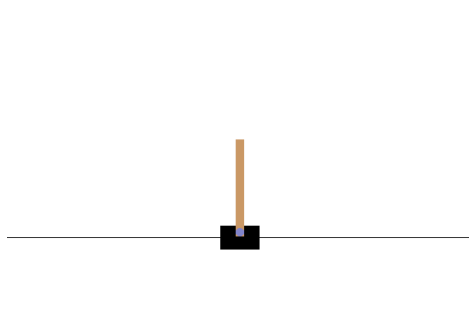

In [44]:
student.evaluate_policy(1, render=True)